# Extração da característica de relação sinal-ruído de dados de EEG

A ideia é utilizar dados fictícios de ruído e sinal "bom"., para criarmos a relação dos dois sinais e obter como resultado um sinal de interesse "limpo".

A partir deste sinal, podemos no contexto de caracterização de foco, ainda extrair os rítmos cerebrais ou então classificar sinais com a presença ou não de foco, de forma que as amostras de sinais extraídas de um buffer sejam rotuladas com com a presença ou não de foco.

Esta atividade pode ser realizada em conjunto com um classificador comumente utilizado, como é o caso do SVM. Neste caso, uma porcetagem das amostras são utilizadas para treino e o restante para teste (p.e. 30 e 70% respectivamente).

In [89]:
## Import Libs
import numpy as np
import mne
from scipy.signal import welch
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

In [90]:
# definição do info (MNE)

n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

<Info | 8 non-empty values
 bads: []
 ch_names: F3, Fz, F4, C3, Cz, C4, P3, P4
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>

In [91]:
# Dados do teste final (amostra)
data = ['../Nathalia/teste/OpenBCI-RAW-2023-11-07_18-21-54 questionario final natalia.txt']
data_ob = [np.loadtxt(txt, delimiter=',', skiprows=5, usecols=range(1, 9)) for txt in data]

# Dados do basal para o teste final
data_basal = ['../Nathalia/teste/OpenBCI-RAW-2023-11-07_18-20-44 padrao um min basal natalia.txt']
data_basal_ob = [np.loadtxt(txt, delimiter=',', skiprows=5, usecols=range(1, 9)) for txt in data_basal]

# Inicia depois de 20seg pra evitar o ruido inicial
inicio_basal = sfreq * 20
# 30 seg de basal
final_basal = inicio_basal + sfreq * 30
data_basal = data_basal_ob[0][inicio_basal:final_basal,:]

# inicia depois de 2 min pra evitar o ruido inicial
inicio_amostra = sfreq * 120         
# 5 minutos de amostra         
final_amostra = inicio_amostra + sfreq * 60 * 5
data_amostra = data_ob[0][inicio_amostra:final_amostra,:]


In [92]:
# Cria MNE da amostra e aplica filtros para a amostra (sem normalização e welch pois ainda será feito a classificação)
data_amostra_mne = mne.io.RawArray(data_amostra.T, info)
data_amostra_mne.notch_filter(freqs=60)
data_amostra_mne.filter(l_freq=4, h_freq=100)

# Cria MNE do basal, aplica filtros, converte para o dominio da frequencia e normaliza
data_noise_basal_mne = mne.io.RawArray(data_basal.T, info)
data_noise_basal_mne.notch_filter(freqs=60)
data_noise_basal_mne.filter(l_freq=4, h_freq=100)
freqs, data_noise_basal_mne_dominio_frequencia = welch(data_noise_basal_mne.get_data(), fs=250, nperseg=1024, noverlap=512)
scaler = StandardScaler()
fft_result_basal = scaler.fit_transform(data_noise_basal_mne_dominio_frequencia)

Creating RawArray with float64 data, n_channels=8, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

In [93]:
## Variaveis para o calculo dos buffers e do overlap entre eles
tamanho_amostra = 5 * 60
tamanho_amostra_pontos = tamanho_amostra * sfreq
tamanho_buffer = 5
tamanho_buffer_pontos = tamanho_buffer * sfreq
passo = 1 * 250
overlap = 4 * 250

In [94]:
# Definir os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz

In [95]:
# criando amostras de 5 segundos
amostras_alvo = []
amostras_descarte = []
amostras_theta = []

jump = tamanho_buffer
size = sfreq * jump    # quantidade de pontos avaliados

[30, 0, 4, 266]
Amostra alvo: 270
Amostra descarte: 30


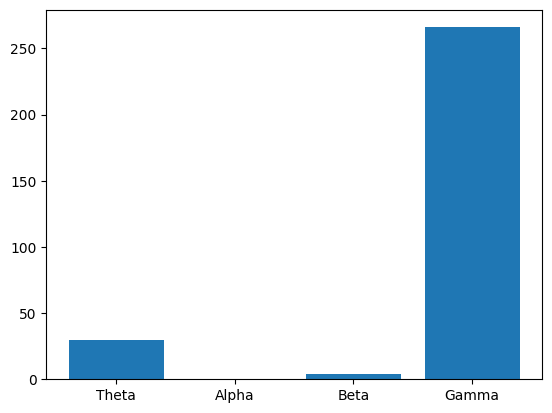

In [96]:
# Dicionário para armazenar as amostras (f = foco, nf = não-foco)
sample = {'f':[], 'nf':[]}

# Resultados para mostrar a porcentagem de cada banda
results = [0, 0, 0, 0]

# Loop para criar as amostras e buffers
for i in range(0, data_amostra_mne.n_times, passo):
    if i + size < data_amostra_mne.n_times:
        cut = data_amostra_mne.copy().crop(tmin=data_amostra_mne.times[i], tmax=data_amostra_mne.times[i]+jump)
    else:
        cut = data_amostra_mne.copy().crop(tmin=data_amostra_mne.times[i], tmax=data_amostra_mne.times[-1])  
    # Número de pontos por segmento
    nperseg = 128
    # Quantidade de sobreposição entre segmentos
    noverlap = nperseg // 2

    cut = cut.get_data()

    
    # transformando para o dominio da frequencia
    freqs, psd = welch(cut, fs=sfreq, nperseg=nperseg, noverlap=noverlap)
    # realizando a média dos 8 eletrodos
    psd_media = np.average(psd, axis=0)

    # Encontrar os índices correspondentes às frequências de interesse
    theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
    alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
    beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
    gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

    # Calcular a potência em cada banda de frequência por meio da integração da PSD
    bands = [np.sum(psd_media[theta_idxs]), np.sum(psd_media[alpha_idxs]), np.sum(psd_media[beta_idxs]), np.sum(psd_media[gamma_idxs])]
    # calculando a pontuação de cada banda para mostrar a porcentagem futura
    results[np.argmax(bands)] += 1

    # Se a banda gamma ou alfa possuir a maior pontuação, adicione a amostra ao grupo alvo
    if np.argmax(bands) == 2 or np.argmax(bands) == 3:
        sample['f'].append(psd_media)
    # Caso contrário, adicione a amostra ao grupo de descarte
    else:
        sample['nf'].append(psd_media)

print(results)
plot = plt.bar(['Theta', 'Alpha', 'Beta', 'Gamma'], results)

print("Amostra alvo: " + str(len(sample['f'])))
print("Amostra descarte: " + str(len(sample['nf'])))

In [97]:
# Estimando o ruído de fundo (utilizando o sinal basal)

# média da potência no intervalo de tempo sem estímulo
base_power = np.average(fft_result_basal)
# média das médias de potência de todos os canais para estimar o ruído de fundo
estimated_background_noise = base_power
print(estimated_background_noise)

5.5402942359462e-17


Vamos calcular o SNR de "banda estreita". Pode ser observado pela seguinte equação:

$SNR_{banda\ estreita} = 10 \cdot \log_{10}\left(\frac{\text{energia total do espectro}}{\text{média das amplitudes nas frequências vizinhas}}\right)$

Já o SNR de banda larga é definido da seguinte forma:

$SNR_{banda\ larga} = 10 \cdot \log_{10}\left(\frac{\text{energia total do espectro}}{\text{energia total do espectro de amplitude}}\right)$

In [99]:
# Calculando o SNR para todas as amostras, foco e não foco.
data_focus = sample['f'] + sample['nf']

# Subtrai a potencia estimada de ruido
target_amplitudes_adjusted = data_focus - estimated_background_noise

# Narrow Band
narrow_band_SNR = 10 * np.log10(target_amplitudes_adjusted / estimated_background_noise)
print("\n****Narrow Band****")
print(narrow_band_SNR)
print(narrow_band_SNR.shape)

# Wide Band
total_power = np.sum(target_amplitudes_adjusted)
wide_band_SNR = 10 * np.log10(target_amplitudes_adjusted / total_power)
print("\n****Wide Band****")
print(wide_band_SNR)
print(wide_band_SNR.shape)



****Narrow Band****
[[162.99102684 172.55633746 176.3303852  ... 142.8173278  128.66419247
  115.51809564]
 [154.40874383 164.4317158  169.79888733 ... 142.88451493 128.18446283
  115.34955027]
 [156.51810502 166.18696028 171.33744321 ... 142.67270644 128.65967748
  116.09711458]
 ...
 [162.76062369 169.52909828 175.98642765 ... 143.81766289 126.51906515
  113.31822649]
 [159.7434925  169.75406764 175.40395596 ... 143.72968537 126.44841487
  114.65414792]
 [160.65764825 170.2004781  176.49156967 ... 143.61887182 126.6645682
  114.80586354]]
(300, 65)

****Wide Band****
[[-45.95625812 -36.39094749 -32.61689976 ... -66.12995716 -80.28309249
  -93.42918932]
 [-54.53854113 -44.51556915 -39.14839763 ... -66.06277003 -80.76282212
  -93.59773469]
 [-52.42917994 -42.76032468 -37.60984174 ... -66.27457852 -80.28760748
  -92.85017038]
 ...
 [-46.18666127 -39.41818668 -32.9608573  ... -65.12962207 -82.42821981
  -95.62905847]
 [-49.20379245 -39.19321732 -33.543329   ... -65.21759958 -82.49887009

### Tarefa para aplicação das características SNR:

Agora que temos os dois vetores de características SNR, podemos utilizar buffers com e sem a evocação dos rítmos que caracterizam o foco.

#### Divisão dos dados

Utilizando a iteração (por exemplo, de 5 segundos caracterizada pela janela) realizada no sinal a cada ~1 segundo, realize a rotulação dos dados de interesse (Beta e Gamma). Ou seja, cada amostra sera um sinal de 5 segundos (1250 pontos de 8 canais). A janela que não for qualificada como Beta ou Gama por exemplo, poderá ser rotulada com "desfoque". Se acharem interessante, adicionar rótulos do ritmo Theta também.

No caso do sinal que representa o basal (se tiverem) poderá pegar um único sinal de aproximadamente 30 segundos para ser utilizado na equação de ruído, que irá ter como resultado um único valor. Lembrando que o valor de ruído deve atuar no sinal no domínio da frequência.

#### Classificação

Em nossos dados simulados, temos 150.000 pontos com 8 canais. A utilização desses dados funcionará da seguinte forma para a criação do vetor de características:

- 150.000 (pontos totais) / 250 (taxa de amostragem) = 600 segundos
- 600 / 5 (tamanho da janela sem sobreposição) = 120 amostras

| 1   | SNRw1                | SNRw2 | ... | SNRw8 | SNRn1 | SNRn2 | ... | SNRn8 |
|-----|----------------------|-------|-----|-------|-------|-------|-----|-------|
| 2   | [w1, w2, ..., w1250] |       |     |       |       |       |     |       |
| 3   |                      |       |     |       |       |       |     |       |
| ... |                      |       |     |       |       |       |     |       |
| 120 |                      |       |     |       |       |       |     |       |

- Agora transforme cada um dos vetores de pontos no domínio da frequência (1250 pontos) em um único valor real. Neste caso pode ser utilizado tanto a média como a mediana (ou ambos). Se utilizarmos as duas, teremos no final 32 colunas de características:
    - 8 canais
    - SNR narrow e SNR wide (2)
    - Média e mediana (2)

| 1   | 1   | ... | 32 |
|-----|-----|-----|----|
| 2   | w'  | ... |    |
| 3   | ... |     |    |
| ... |     |     |    |
| 120 |     |     |    |



Após obter o vetor de característica, realizar a divisão dos dados em treinamento e teste (normalmente uma proporção de 70 e 30% respectivamente) e aplicar para o classificador SVM.

**PLUS**: Ao final da tarefa, verificar a melhora dos resultados utilizando um seletor de características. Neste caso, podemos utilizar o RFE (*Recursive Feature Elimination*) em uma fase anterior a classificação para reduzir as 32 características se for necessário.



In [102]:
labels = [1] * len(sample['f']) + [0] * len(sample['nf'])  # 1 para foco e 0 para não foco

# Dividir os dados em treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(data_focus, labels, test_size=0.3, random_state=42)

# Normalização dos dados de treino e de teste
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Criando o classificador SVM
svm_model = SVC(kernel='linear')

# Aplicando a seleção de características (RFE)
selector = RFE(svm_model, n_features_to_select=32, step=1)  # Reduzindo para 32 características mais relevantes
# Treinando o modelo SVM com RFE
selector = selector.fit(X_train_scaled, y_train)

# Treinando o modelo SVM sem RFE
svm_model.fit(X_train_scaled, y_train)

# Realizando a predição com RFE
y_pred = svm_model.predict(X_test_scaled)
# Realizando a predição sem RFE
y_predRFE = selector.predict(X_test_scaled)

print("\n***Relatório sem RFE***\n")
# Avaliação do modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório:\n", classification_report(y_test, y_pred))
print("Amostras com foco:", y_pred.tolist().count(1))
print("Amostras sem foco:", y_pred.tolist().count(0))

print("\n***Relatório com RFE***\n")
# Avaliação do modelo
print("Acurácia:", accuracy_score(y_test, y_predRFE))
print("Relatório:\n", classification_report(y_test, y_predRFE))
print("Amostras com foco:", y_predRFE.tolist().count(1))
print("Amostras sem foco:", y_predRFE.tolist().count(0))




***Relatório sem RFE***

Acurácia: 0.9666666666666667
Relatório:
               precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.98      0.99      0.98        82

    accuracy                           0.97        90
   macro avg       0.92      0.87      0.89        90
weighted avg       0.97      0.97      0.97        90

Amostras com foco: 83
Amostras sem foco: 7

***Relatório com RFE***

Acurácia: 0.9777777777777777
Relatório:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.98      1.00      0.99        82

    accuracy                           0.98        90
   macro avg       0.99      0.88      0.92        90
weighted avg       0.98      0.98      0.98        90

Amostras com foco: 84
Amostras sem foco: 6
